# AIM

Learn through implementation the use of HMMs and RNNs in serving as prediction models

# Hidden Markov Models

In [ ]:
# helper functions

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(2)

def norm(x): 
    '''
    Return the input normalized to have sum of 1. 
    '''
    return(x/x.sum())

def row_norm(x):
    '''
    Return the input normalized so that each row sums to 1. 
    '''
    return x / x.sum(1, keepdims=True)

## Sampling from the HMM 


In [ ]:
def sampleHMM(gamma0, T, E, S):
    '''
Sample from the HMM

Parameters
----------
gamma0
    initial distribution over states of the HMM
T
    transition matrix of size K x K
E
    emission matrix size K x L
S
    sequence length

Returns
-------
x
    Vector of hidden states
y
    Vector of observations
    '''
    K = gamma0.size
    L = E.shape[1]
    x = np.zeros(S, dtype = np.int32)
    y = np.zeros(S, dtype = np.int32)
    x[0] = np.random.choice(K, p=gamma0)
    y[0] = np.random.choice(L, p=E[x[0], :])
    for t in range(1,S):
        x[t] = np.random.choice(K, p = T[x[t-1], :])
        y[t] = np.random.choice(L, p = E[x[t], :])
    return (x,y)

Text(0.5, 1.0, 'Observations y')

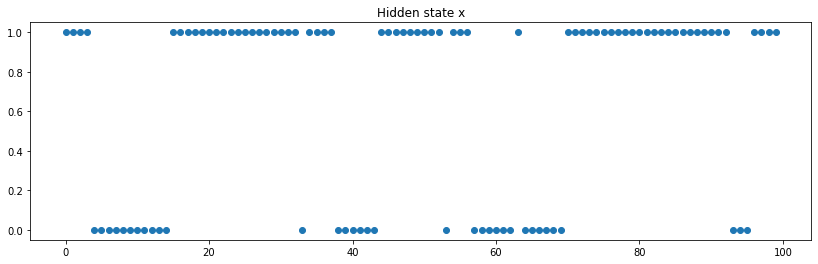

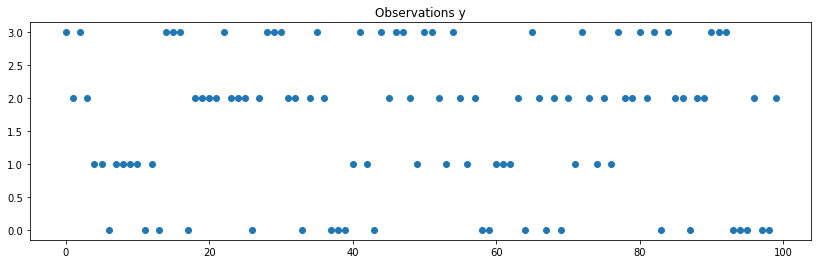

In [ ]:
# test a 2-state HMM and sample to observe outputs

gamma0_true = np.array([0., 1.]) # start in state 1 (rather than 0)
T_true = np.array([[0.8, 0.2], [0.1, 0.9]]) # usually stay in the same state, a "sticky" HMM
E_true = np.array([[0.4, 0.4, 0.1, 0.1], [0.1, 0.1, 0.4, 0.4]]) 

np.random.seed(3)
x,y = sampleHMM(gamma0_true, T_true, E_true, S = 100)

plt.figure(figsize=(14,4))
plt.plot(x, "o")
plt.title("Hidden state x")

plt.figure(figsize=(14,4))
plt.plot(y, "o")
plt.title("Observations y")

## Forwards-backwards

For forward pass initialized
$$ f_{1:} = \text{norm}( \gamma_0 \cdot E_{:y_{1}} ) $$ 
where $f = \text{norm}(f_*)$ implies
$$ f_i = \frac{ f^*_i }{ \sum_{i'} f^*_{i'} } $$


At each time point $t$
$$ r_{ti} = \sum_j T_{ji} f_{(t-1)j} $$
$$ f^*_{ti} = r_{ti} E_{iy_t} $$
$$ f_{ti} = \frac{ f^*_{ti} }{ \sum_{i'} f^*_{ti'} } $$


The subsequent time point updates are
$$ r_{t:} = f_{t-1:}T $$
$$ f^*_{t:} = r_{t:} \cdot E_{:y_i} $$
$$ f_{t:} = \frac{ f^*_{t:} }{ \sum_{t'} f^*_{t':} } $$

In [ ]:
def forwards(y, gamma0, T, E):
    '''
Forward pass of forwards-backwards algorithm. 

Parameters
----------
y
    vector of observations, assumed to be in range(E.shape[1])
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
E
    emission matrix size K x L
Returns
-------
f
    forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''
    S = y.size
    K = T.shape[0]
    
    f = np.zeros((S, K))

    f_star = np.multiply(gamma0, E[:,y[0]])
    f[0,:] = f_star / sum(f_star)

    for i in range(1,S):
      r = np.dot(f[i-1,:], T)
      f_star = np.multiply(r, E[:,y[i]])
      f[i,:] = f_star / sum(f_star)
    return f

For backwards pass time point updates are
$$ q_{ti} = \sum_j{ E_{jy_{t+1} }} \cdot b_{t+1 j} $$
$$ b_{ti} = T_{ij} \cdot q_{ti} $$

In [ ]:
def backwards(y, T, E):
    '''
Backwards pass of forwards-backwards algorithm. 

Parameters
----------
y
    vector of observations, assumed to be in range(E.shape[1])
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
E
    emission matrix size K x L

Returns
-------
b
    Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    S = y.size
    K = T.shape[0]

    b = np.ones((S, K))

    for i in range(S-2, -1, -1):
      b[i,:] = np.dot( T, np.multiply(E[:,y[i+1]], b[i+1,:]))
    return b

In [ ]:
# combine forwards and backwards to get the posterior
def forwards_backwards( y, gamma0, T, E ):
    f = forwards(y, gamma0, T, E) # eq to S x K
    b = backwards(y, T, E)
    gamma = row_norm( f * b ) # gamma[t,k] = P(X[t]=k | y[0:S]) is posterior
    return gamma, f, b

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )

# check forwards_backwards results for correctness
assert( abs(gamma[-1,1] - 0.6397375803142555) < 1e-10  ) 
assert( abs(gamma[-50,1] - 0.9566209571811642) < 1e-10  ) 

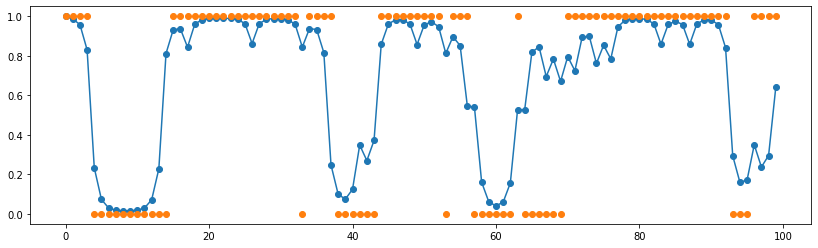

In [ ]:
# compare posterior X over true X

plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

In [ ]:
# how often does posterior X match true X

np.mean((gamma[:,1] > .5) == (x==1))

0.86

Posterior tends towards the correct hidden state 86% of the time

## Baum-Welch


In [ ]:
def baum_welch(y, gamma0, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    y
        vector of observations
    gamma0
        initial distribution of the hidden chain
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j] = P(Y[t]=j | X[t]=i)
  '''  
    K = gamma0.size
    L = 1+max(y)
    S = y.size
    Y = np.zeros([S, L])
    Y[range(S), np.int_(y)] = 1

    # gamma S x K
    # Y S x L

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) )
    E = row_norm( np.random.rand(K, L).astype(np.float32) )

    it = 0
    oldT = T
    oldE = E + tol +1

    while (np.abs(oldT-T).sum() + np.abs(oldE-E).sum() > tol) and (it<maxIt):
        it += 1

        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b = forwards_backwards(y, gamma0, T, E)
        
        # M-step
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], E[:,y[t+1]] * b[t+1,:] ) )
        T = row_norm(Tstar)

        # E update
        E_star = np.dot(gamma.T, Y)
        E = row_norm(E_star)

    return (T, E)

In [ ]:
# check if Baum-Welch can recover true E and T

np.random.seed(2)

T_mle, E_mle = baum_welch(y, gamma0_true)

print("True T:\n", T_true)
print("Infered T:\n", T_mle)
print("Mean absolute error in T: %.3f" % np.mean(np.abs(T_true - T_mle)))

print("True E:\n", E_true)
print("Infered E:\n", E_mle )
print("Mean absolute error in E: %.3f" % np.mean(np.abs(E_true - E_mle)))

assert( abs(E_mle[0,0] - 0.19228533549712362) < 1e-10 )

True T:
 [[0.8 0.2]
 [0.1 0.9]]
Infered T:
 [[0.91 0.09]
 [0.08 0.92]]
Mean absolute error in T: 0.066
True E:
 [[0.4 0.4 0.1 0.1]
 [0.1 0.1 0.4 0.4]]
Infered E:
 [[1.92e-01 3.87e-01 2.20e-01 2.01e-01]
 [2.44e-01 4.46e-13 4.44e-01 3.11e-01]]
Mean absolute error in E: 0.102


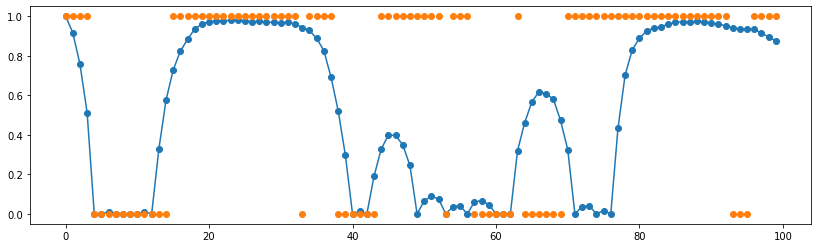

In [ ]:
# compare posterior X over true X

gamma, f, b = forwards_backwards(y, gamma0_true, T_mle, E_mle) 
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

In [ ]:
# how often does posterior X match true X

np.mean((gamma[:,1] > .5) == (x==1))

0.69

Posterior tends towards the correct hidden state 69% of the time, still better than random

In [ ]:
# baum welch but with pseudocount to offset error coming from the recovered E matrix

def baum_welch_with_pseudocount(y, gamma0, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    y
        vector of observations
    gamma0
        initial distribution of the hidden chain
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j] = P(Y[t]=j | X[t]=i)
  '''  
    K = gamma0.size
    L = 1+max(y)
    S = y.size
    Y = np.zeros([S, L])
    Y[range(S), np.int_(y)] = 1

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) )
    E = row_norm( np.random.rand(K, L).astype(np.float32) )

    it = 0
    oldT = T
    oldE = E + tol +1

    while (np.abs(oldT-T).sum() + np.abs(oldE-E).sum() > tol) and (it<maxIt):
        it += 1

        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b = forwards_backwards(y, gamma0, T, E)
        
        # M-step
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], E[:,y[t+1]] * b[t+1,:] ) )
        T = row_norm(Tstar + 1)

        # E update with pseudocount
        E_star = np.dot(gamma.T, Y)
        E = row_norm(E_star + 1)

    return (T, E)

In [ ]:
np.random.seed(2)

T_mle, E_mle = baum_welch_with_pseudocount(y, gamma0_true)

assert( abs(E_mle[0,0] - 0.298322068734388) < 1e-10 )

print("True T:\n", T_true)
print("Infered T:\n", T_mle)
print("Mean absolute error in T: %.3f" % np.mean(np.abs(T_true - T_mle)))

print("True E:\n", E_true)
print("Infered E:\n", E_mle )
print("Mean absolute error in E: %.3f" % np.mean(np.abs(E_true - E_mle)))

True T:
 [[0.8 0.2]
 [0.1 0.9]]
Infered T:
 [[0.76 0.24]
 [0.11 0.89]]
Mean absolute error in T: 0.026
True E:
 [[0.4 0.4 0.1 0.1]
 [0.1 0.1 0.4 0.4]]
Infered E:
 [[0.3  0.43 0.16 0.11]
 [0.19 0.07 0.41 0.33]]
Mean absolute error in E: 0.050


Make sure the assertion passes! These estimates are a lot closer to the ground truth than without the pseudocounts. That will result in a better recovery of x too: 

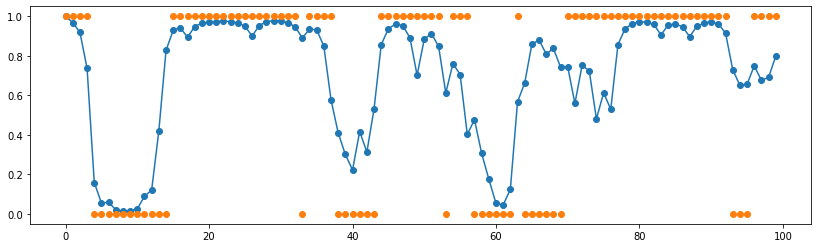

In [ ]:
# compare posterior X over true X

gamma, f, b = forwards_backwards(y, gamma0_true, T_mle, E_mle) 
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

In [ ]:
np.mean((gamma[:,1] > .5) == (x==1))

0.85

Posterior tends towards the correct hidden state 85% of the time, an increase in accuracy from 69%

# Real data: single cell bisulphite sequencing

Data is of the single cell Bisulphite sequencing ("scBS-seq") data from the DeepCpG paper.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 

scBSseq = np.load("/content/drive/MyDrive/Junior Year/Spring/ML4FG/A3/scBSseq.npz")

meth_mat = scBSseq["meth_mat"] # positions x cells matrix of counts of methylated CpGs
unmeth_mat = scBSseq["unmeth_mat"] # positions x cells matrix of counts of unmethylated CpGs (i.e. C got converted to T)
positions = scBSseq["positions"] # genomic position of each CpG
chroms = scBSseq["chroms"] # chromomsome of each CpG
cell_names = scBSseq["cell_names"] # cell type and an arbitrary ID
cell_names

array(['2i_1', '2i_10', '2i_11', '2i_12', '2i_2', '2i_3', '2i_4', '2i_5',
       '2i_6', '2i_7', '2i_8', '2i_9', 'MII_1', 'MII_10', 'MII_11',
       'MII_12', 'MII_2', 'MII_3', 'MII_4', 'MII_5', 'MII_6', 'MII_7',
       'MII_8', 'MII_9', 'Ser1', 'Ser10', 'Ser11', 'Ser12', 'Ser13',
       'Ser14', 'Ser15', 'Ser16', 'Ser17', 'Ser18', 'Ser19', 'Ser2',
       'Ser20', 'Ser3', 'Ser4', 'Ser5', 'Ser6', 'Ser7', 'Ser8', 'Ser9'],
      dtype='<U6')

## Exploratory data analysis

Explore to see how sparse the data is

0.2968330165185542

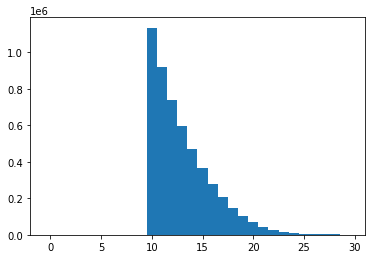

In [ ]:
import matplotlib.pyplot as plt

total_counts = meth_mat + unmeth_mat
ncells_with_reads = (total_counts > 0).sum(1)
plt.hist(ncells_with_reads, np.arange(-.5,30.5) )
np.mean(total_counts > 0)

About 30% of entries have data

Text(0.5, 0, 'PC')

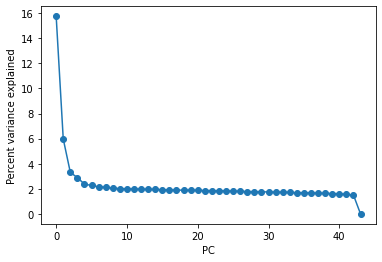

In [ ]:
# apply PCA for eda

# adding psuedocount bc there is so much missing data
# w psuedocount we're only looking at CpGs that have data for at least 25 cells
pseudocount = 0.25
meth_level = ( meth_mat + pseudocount) / (total_counts + 2 * pseudocount)
meth_level = meth_level[ncells_with_reads >= 25,:] # only consider CpG positions with reads in 25 (out of 44) cells

meth_level_centered = meth_level - meth_level.mean(1, keepdims=True) # remove the per position mean

# u,s,vh = np.linalg.svd(meth_level_centered, full_matrices=True) 
# use SVD to do PCA
import torch
torch.manual_seed(0)
usvh = torch.pca_lowrank( torch.tensor(meth_level_centered).to("cuda"), q=44, center=False, niter=10)
u,s,vh = [ g.cpu().numpy() for g in usvh ]
vh = vh.transpose()

plt.plot(100 * s**2 / np.sum(s**2), "o-")
plt.ylabel("Percent variance explained")
plt.xlabel("PC")

Graph depicts that most of the variation is captured by the first two PCs

In [ ]:
vh.shape

(44, 44)

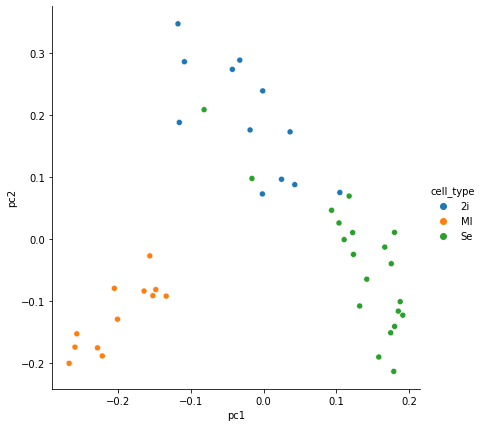

In [ ]:
# plot the first two PCs

import seaborn as sns
import pandas as pd

df = pd.DataFrame(
    { "pc1" : vh[0,:],
      "pc2" : vh[1,:],
      "cell_type" : [ cn[:2] for cn in cell_names ] } )

_ = sns.pairplot(x_vars = ["pc1"], y_vars = ["pc2"], hue = "cell_type", data = df, height=6 )

Plot shows that cell type derives much of the variation in the data 

## Applying the HMM

PCA can't handle missingness and also does not take into account the sequential nature of the data. Therefore it is better in this case to use HMMs especially since the data at each CpG position is a vector of methylated and unmethylated counts, which can be easily modeled using a binomial likelihood

In [ ]:
# change the forwards-backwards algorithm to be agnostic to the form of the likelihood

def forwards_generic(gamma0, T, O):
    '''
Forward pass of forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''  
    S = O.shape[1]
    K = T.shape[0]

    f = np.zeros((S, K))
    
    f_star = np.multiply(gamma0, O[:,0])
    f[0,:] = norm(f_star)

    for i in range(1,S):
      r = np.dot(f[i-1,:], T)
      f_star = np.multiply(r, O[:,i])
      f[i,:] = norm(f_star)

    return f

def backwards_generic(T, O):
    '''
Backwards pass of forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    S = O.shape[1]
    K = T.shape[0]

    b = np.ones((S, K))

    for i in range(S-2, -1, -1):
      b_star = np.dot( T, np.multiply(O[:,i+1], b[i+1,:]) )
      b[i,:] = norm(b_star)
    return b

def forwards_backwards_generic(gamma0, T, O):
    '''
Forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
gamma
    S x K matrix: posterior gamma[t,k] = P(X[t]=k | y[0:S])
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    f = forwards_generic(gamma0, T, O) 
    b = backwards_generic(T, O)
    gamma = row_norm( f * b ) 
    return gamma, f, b

def forwards_backwards_check( y, gamma0, T, E ):
    O = E[:,y] # calculate O from E and y
    return forwards_backwards_generic(gamma0, T, O)

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )
gamma_check, f, b = forwards_backwards_check( y, gamma0_true, T_true, E_true )
assert( abs(gamma[-1,1] - gamma_check[-1,1]) < 1e-10  )

## Binomial HMM

To make a version of forward-backwards for our binomial vectors. We want 
$$ O_{kt} = P(Y_t | X_t = k) = \prod_{n=1}^N P(Y_{tn} | X_t = k) $$ 

The binomial likelihood for an individual cell is 
$$ P(Y_{tn} | X_t = k) = Bin( M_{tn} | M_{tn} + U_{tn}, E_{k n} ) = E_{k n}^{M_{tn}} (1-E_{k n})^{U_{tn}} $$
where $M_{tn}$ and $U_{tn}$ are the methylated and unmethylated counts respectively and $E_{ij} = P(Y_{tj} = 1 | X_t = i )$ is a matrix of binomial probabilities 

<br>

$\log O_{kt}$ in terms of $E$, $M$ and $U$: 
$$\log O_{kt} = \sum_{n=1}^N M_{tn} \log(E_{kn}) + U_{tn} \log( 1 - E_{kn}) $$

$$\log O = \log E \cdot M^T + \log(1 - E) \cdot U^T $$


In [ ]:
def forwards_backwards_binomial( meth_mat, unmeth_mat, gamma0, T, E ):
    #calculate logO
    logO = np.dot(np.log(E), meth_mat.T) + np.dot(np.log1p(1-E-1), unmeth_mat.T)
    logO -= logO.max(0,keepdims=True) # more numerically stable
    O = np.exp(logO)

    # print("logO shape: ", logO.shape)
    
    gamma, f, b = forwards_backwards_generic(gamma0, T, O)
    return gamma, f, b, O

In [ ]:
# use PCA to initialize E for HMM
K = 10 # use top 10 PCs

# rescale PCs to get valid probabilities
E_init = vh[:K,:]
E_init -= E_init.min(1, keepdims=True)
E_init /= E_init.max(1, keepdims=True)
E_init = 0.8 * E_init + 0.1

# transition matrix
T_init = row_norm(np.identity(K) + 1/K)

# test forwards backwards

S = 30000 # np.sum(chroms=='1') # just run on chromosome 1

gamma0 = np.full(K,1/K)
gamma, f, b, O = forwards_backwards_binomial( meth_mat[:S,:], unmeth_mat[:S,:], gamma0, T_init, E_init )

print("E shape: ", E_init.shape)
print("meth shape: ", meth_mat[:S,:].shape)
print("gamma shape: ", gamma.shape)
print(gamma[-1,4])

assert( abs(gamma[-1,4] - 1.0168727093165696e-06) < 1e-10  )

E shape:  (10, 44)
meth shape:  (30000, 44)
gamma shape:  (30000, 10)
1.0168727093164815e-06


## Baum-Welch for the binomial HMM

Implement Baum-Welch to find parameters E and T for binomial HMM applied to the methylation data

In [ ]:
def baum_welch_binomial(meth_mat, unmeth_mat, gamma0, E_init = None, T_init = None, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    meth_mat
        S x L matrix of methylated counts
    unmeth_mat
        S x L matrix of unmethylated counts
    gamma0
        initial distribution of the hidden chain
    E_init
        Optional initialization of emission matrix E. 
    T_init
        Optional initialization of transition matrix T. 
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j], the binomial probability of methylation in cell j, given X[t]=i. 
  '''  
    K = gamma0.size
    L = meth_mat.shape[1]
    S = meth_mat.shape[0]
    
    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) ) if (T_init is None) else T_init
    E = 0.1 + 0.8 * np.random.rand(K,L) if (E_init is None) else E_init # don't put values too close to 0 or 1

    it = 0

    param_change = np.inf
    
    while (param_change > tol) and (it<maxIt):
        it += 1
        print("Iteration: %i Param change: %.3g" % (it, param_change))
        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b, O = forwards_backwards_binomial(meth_mat, unmeth_mat, gamma0, T, E )
        assert(not np.any(np.isnan(gamma)))

        # M-step 
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], O[:,t+1] * b[t+1,:] ) )
        T = row_norm(Tstar)

        # M-step update for E
        E = np.divide(gamma.T @ meth_mat + 1, gamma.T @ (meth_mat + unmeth_mat) + 2 )

        assert(not np.any(np.isnan(E)))
        
        param_change = max( np.abs(oldT-T).max() , np.abs(oldE-E).max() )

    return (T, E, gamma)

In [ ]:
# test on first 30k positions
# can't test estimates of T and E against ground truth so instead approach is to hold out counts for entries and try to imipute them

test_meth = meth_mat[:S, :]
test_unmeth = unmeth_mat[:S, :]
test_total = test_meth + test_unmeth
to_mask = test_total >= 2 
print(to_mask.mean())
test_meth_masked = test_meth.copy() 
test_meth_masked[to_mask] = 0
test_unmeth_masked = test_unmeth.copy() 
test_unmeth_masked[to_mask] = 0

print(E_init.shape)

T,E,gamma = baum_welch_binomial( test_meth_masked, test_unmeth_masked, gamma0, E_init = E_init, T_init = T_init, tol = 0.01 )

0.13284242424242423
(10, 44)
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.763
Iteration: 3 Param change: 0.256
Iteration: 4 Param change: 0.177
Iteration: 5 Param change: 0.299
Iteration: 6 Param change: 0.184
Iteration: 7 Param change: 0.0812
Iteration: 8 Param change: 0.0568
Iteration: 9 Param change: 0.0465
Iteration: 10 Param change: 0.0543
Iteration: 11 Param change: 0.0539
Iteration: 12 Param change: 0.0459
Iteration: 13 Param change: 0.0348
Iteration: 14 Param change: 0.0246
Iteration: 15 Param change: 0.0198
Iteration: 16 Param change: 0.0223
Iteration: 17 Param change: 0.0253
Iteration: 18 Param change: 0.0289
Iteration: 19 Param change: 0.0334
Iteration: 20 Param change: 0.0377
Iteration: 21 Param change: 0.0392
Iteration: 22 Param change: 0.0364
Iteration: 23 Param change: 0.0314
Iteration: 24 Param change: 0.0266
Iteration: 25 Param change: 0.0217
Iteration: 26 Param change: 0.0177
Iteration: 27 Param change: 0.0149
Iteration: 28 Param change: 0.0141
Iteratio

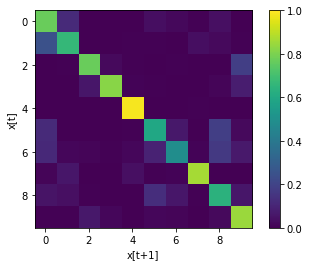

In [ ]:
# learnt transition matrix T
# shows HMM mostly stays in the same state

plt.imshow(T,vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("Hidden state")
plt.xlabel("x[t+1]")
_ = plt.ylabel("x[t]")

Mostly here the HMM stays in the same state, but various other transitions  have substantial mass too. 

We can also look at the emission matrix, which shows clear patterns of states that correspond to methylation shared across cells of a specific type. 

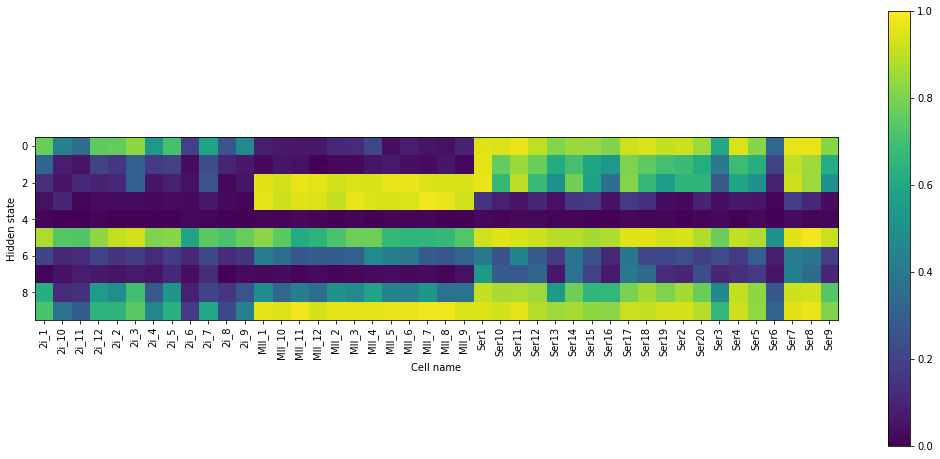

In [ ]:
# emission matrix
# shows patterns of states corresponding to methylation being the same across cells of specific types

plt.figure(figsize=(18,8))
plt.imshow(E, vmin=0, vmax=1)
_ = plt.xticks(np.arange(len(cell_names)), cell_names, rotation="vertical")
plt.colorbar()
plt.xlabel("Cell name")
_ = plt.ylabel("Hidden state")

In [ ]:
# calculate probability of correct prediction

Z = gamma @ E
Y_obs = test_meth / test_total
correct_pred = (Y_obs[to_mask]>.5) == (Z[to_mask]>.5)
correct_pred.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.878427391760573

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


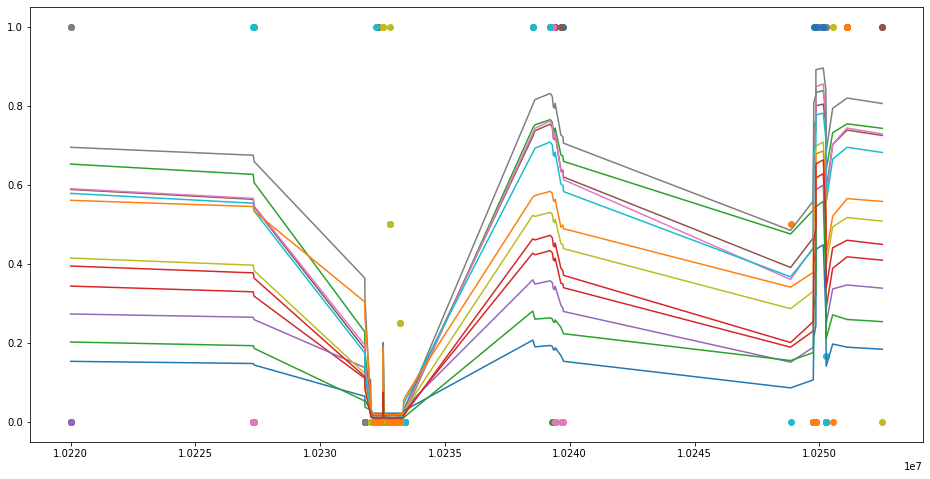

In [ ]:
# visualize predictions

(cpg_start,cpg_end) = (10232143, 10233428)

window = 20000

in_cpg = np.logical_and( chroms == "1" , np.logical_and( cpg_start - window < positions , positions < cpg_end + window ))

meth_mat[in_cpg,:]
unmeth_mat[in_cpg,:]

y = meth_mat[in_cpg,:] / ( unmeth_mat[in_cpg,:] + meth_mat[in_cpg,:] )

plt.figure(figsize=(16,8))
_ = plt.plot( positions[in_cpg], y[:,:12], "o")
_ = plt.plot( positions[in_cpg], Z[in_cpg[:S],:12], "-")

In [ ]:
# observe impact of varying the hidden states and how it impacts imputation accuracy and run time

from datetime import datetime

k_list = []
imp_acc = []
run_time = []

for K in range(1,11):
  k_list.append(K)

  E_init = vh[:K,:]
  E_init -= E_init.min(1, keepdims=True)
  E_init /= E_init.max(1, keepdims=True)
  E_init = 0.8 * E_init + 0.1

  T_init = row_norm(np.identity(K) + 1/K)

  S = 30000 # np.sum(chroms=='1') # just run on chromosome 1

  gamma0 = np.full(K,1/K)

  test_meth = meth_mat[:S, :]
  test_unmeth = unmeth_mat[:S, :]
  test_total = test_meth + test_unmeth
  to_mask = test_total >= 2 # often you would use a random set of entries
  print(to_mask.mean()) # how many entries are we testing on? 
  test_meth_masked = test_meth.copy() 
  test_meth_masked[to_mask] = 0
  test_unmeth_masked = test_unmeth.copy() 
  test_unmeth_masked[to_mask] = 0

  print(E_init.shape)

  start = datetime.now()
  T,E,gamma = baum_welch_binomial( test_meth_masked, test_unmeth_masked, gamma0, E_init = E_init, T_init = T_init, tol = 0.01 )
  run_time.append((datetime.now() - start).total_seconds())

  # TODO: calculate Z as the expected Y given the posterior over X. Should be S x L
  Z = gamma @ E
  Y_obs = test_meth / test_total
  correct_pred = (Y_obs[to_mask]>.5) == (Z[to_mask]>.5)
  imp_acc.append( correct_pred.mean() )

0.13284242424242423
(1, 44)
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


0.13284242424242423
(2, 44)
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.802
Iteration: 3 Param change: 0.0875
Iteration: 4 Param change: 0.0205
0.13284242424242423
(3, 44)
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.822
Iteration: 3 Param change: 0.261
Iteration: 4 Param change: 0.119
Iteration: 5 Param change: 0.0815
Iteration: 6 Param change: 0.0328
Iteration: 7 Param change: 0.0137
0.13284242424242423
(4, 44)
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.729
Iteration: 3 Param change: 0.23
Iteration: 4 Param change: 0.125
Iteration: 5 Param change: 0.0734
Iteration: 6 Param change: 0.0531
Iteration: 7 Param change: 0.0345
Iteration: 8 Param change: 0.0242
Iteration: 9 Param change: 0.0195
Iteration: 10 Param change: 0.0177
Iteration: 11 Param change: 0.0171
Iteration: 12 Param change: 0.0165
Iteration: 13 Param change: 0.0159
Iteration: 14 Param change: 0.0157
Iteration: 15 Param change: 0.0156
Iteration: 16 Param change: 0.0154
Iteratio

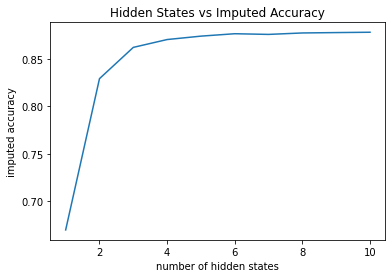

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_list, imp_acc, label="imputed accuracy")

plt.xlabel("number of hidden states")
plt.ylabel("imputed accuracy")
plt.title("Hidden States vs Imputed Accuracy")
plt.show()


Increasing the number of hidden states increases the imputed accuracy, but there's diminishing returns on how much increase there is from each additional hidden state

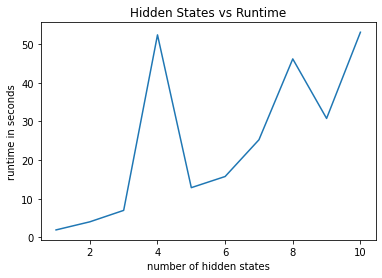

In [ ]:
plt.plot(k_list, run_time, label="runtime")

plt.xlabel("number of hidden states")
plt.ylabel("runtime in seconds")
plt.title("Hidden States vs Runtime")
plt.show()


While increasing the number of hidden states does seem to increase the runtime, the function isn't entirely just increasing, which could be useful for getting better results with more hidden states without having to sacrifice runtime

# RNNs

In deep learning RNNs are often used to handle sequential data. 

## Vanilla RNN

In [ ]:
import torch.nn as nn
import torch 
import torch.nn.functional as F

class MyVanillaRNNCell(nn.Module): # individual computation unit for the RNN
    
    def __init__(self, input_size, hidden_size):
        super(MyVanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, x, h_in):
        """
        Forward computation. 
        
        Parameters
        ----------
        x : torch.tensor
            [batch_size x input_size] input
        h_in : torch.tensor
            [batch_size x hidden_size] hidden state from previous time point
            
        Returns
        -------
        h_out : torch.tensor
            [batch_size x hidden_size] new hidden state 
        """
        combined = torch.cat((x, h_in), 1) # concatenate in feature dimension
        h_out = torch.tanh( self.linear(combined) )
        return h_out



In [ ]:
class MyRNNLayer(nn.Module):
    
    def __init__(self, rnn_cell):
        super(MyRNNLayer, self).__init__()
        self.rnn_cell = rnn_cell

    @property
    def hidden_size(self):
        return self.rnn_cell.hidden_size

    @property
    def input_size(self):
        return self.rnn_cell.input_size
        
    def forward(self, x): 
        (seq_len, batch_size, input_size) = x.shape
        hidden = torch.zeros(batch_size, self.hidden_size, device = x.device) # could be an input to the function
        output = torch.zeros(seq_len, batch_size, self.hidden_size, device = x.device)
        for i in range(seq_len): # iterate over sequence
            hidden = self.rnn_cell(x[i,:,:], hidden)
            output[i,:,:] = hidden
        return output

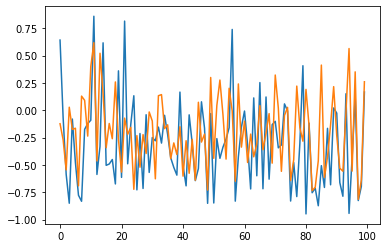

In [ ]:
# run rnn with random input
input_size = 4
hidden_size = 2
rnn_cell = MyVanillaRNNCell(input_size, hidden_size)
rnn = MyRNNLayer(rnn_cell)

x = torch.randn(100, 1, input_size) # random input length 100, batch_size = 1
hidden_state = rnn(x)

_ = plt.plot(hidden_state.detach().numpy().squeeze())

Vanilla RNN isn't very useful because of vanishing gradients

Implement less vanilla RNN cell that has the following
$$ f_t = \sigma( W_f [ x_t , h_{t-1} ]^T + \mu_f ) $$
$$ g_t = \tanh( W_g [ x_t , h_{t-1} ]^T + \mu_g ) $$
$$ h_t = f_t \cdot h_{t-1} + (1 - f_t) \cdot g_t $$

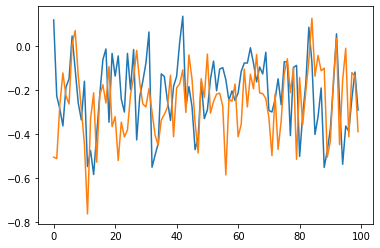

In [ ]:
class MyLessVanillaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLessVanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, x, h_in):
        """
        Forward computation. 
        
        Parameters
        ----------
        x : torch.tensor
            [batch_size x input_size] input
        h_in : torch.tensor
            [batch_size x hidden_size] hidden state from previous time point
            
        Returns
        -------
        h_out : torch.tensor
            [batch_size x hidden_size] new hidden state 
        """
        combined = torch.cat((x, h_in), 1) # concatenate in feature dimension
        f = torch.sigmoid( self.linear(combined) )
        g = torch.tanh( self.linear(combined) )
        h_out = h_in * f + (1 - f) * g
        return h_out

rnn_cell = MyLessVanillaRNNCell(input_size, hidden_size)
rnn = MyRNNLayer(rnn_cell)
output = rnn(x)
_ = plt.plot(output.detach().numpy().squeeze())

In [ ]:
class BasicRNN(nn.Module):
    
    def __init__(self, rnn_layer, output_size):
        super(BasicRNN, self).__init__()
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(rnn_layer.hidden_size, output_size)

    def forward(self, x):
        h = self.rnn_layer(x)
        output = self.linear(h)
        return output

output_size = 3
rnn_cell = MyLessVanillaRNNCell(input_size, hidden_size)
rnn_layer = MyRNNLayer(rnn_cell)
model = BasicRNN(rnn_layer, output_size)
model(x).shape

torch.Size([100, 1, 3])

In [ ]:
class MethModel(nn.Module):
    def __init__(self, rnn_layer, input_size = 2, output_size = 1):
        super(MethModel, self).__init__()
        self.hidden_size = rnn_layer.hidden_size
        self.embed = nn.Linear(input_size, rnn_layer.input_size) # the embed layer runs independently on each pair of meth/unmeth counts
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, meth, unmeth): # meth is seq x batch x cells
        batch_size = meth.shape[1]
        num_cells = meth.shape[2]
        meth = meth.view(meth.shape[0], batch_size * num_cells)
        unmeth = unmeth.view(unmeth.shape[0], batch_size * num_cells)

        # RNN input will be methylated and unmethylated counts
        x = torch.stack((meth,unmeth),2) # seq x (cells x batch) x channels(=meth and unmeth counts)
        x = self.embed(x) # seq x cells(=batch) x channels
        x = F.relu(x)

        h = self.rnn_layer(x) 
        if isinstance(rnn_layer, nn.RNNBase): h = h[0] # torch RNN layers give h[0:t] and h[-1]
        
        output = self.linear(h)
        output = output.view(output.shape[0], batch_size, num_cells, output.shape[-1])
        output = output[:,:,:,0]
        return output

In [ ]:
class CpgDataset(torch.utils.data.Dataset):

    def __init__(self, meth_counts, unmeth_counts, seq_len = 1000):
        super(CpgDataset, self).__init__()
        self.meth_counts = meth_counts
        self.unmeth_counts = unmeth_counts
        self.seq_len = seq_len

    def __getitem__(self, i): 
        return(self.meth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32), 
               self.unmeth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32))
            
    def __len__(self):
        return self.meth_counts.shape[0] // self.seq_len

In [ ]:
import timeit

def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval()

    losses = []
    accuracies = []

    for meth,unmeth in dataloader:
        
        # DataLoader's automatic batching makes batch x seq x cells tensors, 
        # For RNNs we want seq x batch x cells
        meth = meth.transpose(0,1).contiguous() 
        unmeth = unmeth.transpose(0,1).contiguous()

        (meth, unmeth) = ( meth.to(device), unmeth.to(device) ) # transfer data to GPU

        # forward
        logodds = model(meth, unmeth) # the output is seq x batch x cells

        lo = logodds[:-1,:,:] # shift by one since we're doing one-step (i.e. one CpG) ahead prediction
        prob_methylated = torch.sigmoid(lo)

        # calculate binomial loss
        loss = -torch.mean( meth[:-1,:,:] * prob_methylated.log() + unmeth[:-1,:,:] * (1 - prob_methylated.log() ))
        losses.append(loss.detach().cpu().numpy())

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        # calculate accuracy
        meth_sum = meth[1:,:,:] + unmeth[1:,:,:]
        meth_rate = meth[1:,:,:] / meth_sum
        correct = ((meth_rate > .5) == (prob_methylated > .5))[meth_sum > 0]
        accuracy = torch.mean( correct.float() )

        accuracies.append(accuracy.detach().cpu().numpy())  

    return( np.mean(losses), np.mean(accuracies) )

def train_loop(model,
               optimizer,
               train_dataloader, 
               validation_dataloader,
               check_point_filename = '/content/drive/My Drive/scBSseq/rnn_checkpoint.pt',
               max_epochs = 100, 
               patience = 10,
               device = "cuda"):

    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
            (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))
        
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
    
    return(train_accs, val_accs)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# train the methmodel

batch_size = 100
seq_len = 1000

training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0 )

val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0)

hidden_size = 32

rnn_cell = MyLessVanillaRNNCell(input_size = hidden_size, hidden_size = hidden_size) 
rnn_layer = MyRNNLayer(rnn_cell)

model = MethModel(rnn_layer)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 30)

test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0)

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Epoch 1 took 32.26s. Train loss: -0.5014 acc: 0.3864. Val loss: -0.5820 acc: 0.3995. Patience left: 10
Epoch 2 took 31.75s. Train loss: -0.5149 acc: 0.4463. Val loss: -0.5982 acc: 0.5039. Patience left: 10
Epoch 3 took 31.70s. Train loss: -0.5291 acc: 0.5467. Val loss: -0.6154 acc: 0.6340. Patience left: 10
Epoch 4 took 31.73s. Train loss: -0.5443 acc: 0.6783. Val loss: -0.6341 acc: 0.8323. Patience left: 10
Epoch 5 took 31.72s. Train loss: -0.5608 acc: 0.7935. Val loss: -0.6546 acc: 0.7672. Patience left: 10
Epoch 6 took 31.76s. Train loss: -0.5789 acc: 0.7246. Val loss: -0.6773 acc: 0.7240. Patience left: 10
Epoch 7 took 31.78s. Train loss: -0.5988 acc: 0.6858. Val loss: -0.7024 acc: 0.7044. Patience left: 10
Epoch 8 took 31.75s. Train loss: -0.6208 acc: 0.6672. Val loss: -0.7300 acc: 0.6937. Patience left: 10
Epoch 9 took 31.75s. Train loss: -0.6449 acc: 0.6573. Val loss: -0.7604 acc: 0.6878. Patience left: 10
Epoch 10 took 31.78s. Train loss: -0.6712 acc: 0.6519. Val loss: -0.7933 

Text(0, 0.5, 'accuracy')

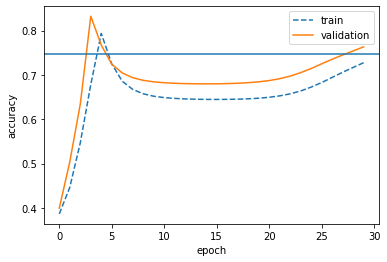

In [ ]:
plt.plot(train_accs,  "--", label="train")
plt.plot(val_accs, label="validation")
plt.axhline(test_acc)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Compare the LessVanillaRNN, VanillaRNN, GRU and LSTM

In [ ]:
def run_model(layer):
  model = MethModel(layer)

  device = "cuda"
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

  train_accs, val_accs = train_loop(model,
                                  optimizer,
                                  train_dataloader, 
                                  validation_dataloader,
                                  check_point_filename = 'rnn_checkpoint.pt',
                                  device = device,
                                  max_epochs = 30)

  test_cpg = chroms == "17"
  test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                batch_size = batch_size, 
                                                num_workers = 0)

  test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
  return (train_accs[-1], val_accs[-1], test_acc)
  

In [ ]:
lessvanillarnn_results = []
rnn_results = []
GRU_results = []
LSTM_results = []

In [ ]:
rnn_results = []
GRU_results = []
LSTM_results = []

In [ ]:
for i in range(3):
  rnn_cell = MyLessVanillaRNNCell(input_size = hidden_size, hidden_size = hidden_size) 
  rnn_layer = MyRNNLayer(rnn_cell)

  lessvanillarnn_results.append( run_model(rnn_layer) )

Epoch 1 took 31.75s. Train loss: -0.5119 acc: 0.6412. Val loss: -0.6022 acc: 0.6761. Patience left: 10
Epoch 2 took 31.73s. Train loss: -0.5297 acc: 0.6412. Val loss: -0.6237 acc: 0.6763. Patience left: 10
Epoch 3 took 31.72s. Train loss: -0.5489 acc: 0.6414. Val loss: -0.6470 acc: 0.6763. Patience left: 10
Epoch 4 took 31.74s. Train loss: -0.5698 acc: 0.6414. Val loss: -0.6726 acc: 0.6763. Patience left: 10
Epoch 5 took 31.70s. Train loss: -0.5926 acc: 0.6414. Val loss: -0.7007 acc: 0.6763. Patience left: 10
Epoch 6 took 31.69s. Train loss: -0.6175 acc: 0.6414. Val loss: -0.7315 acc: 0.6763. Patience left: 10
Epoch 7 took 31.68s. Train loss: -0.6448 acc: 0.6414. Val loss: -0.7653 acc: 0.6763. Patience left: 10
Epoch 8 took 31.74s. Train loss: -0.6746 acc: 0.6414. Val loss: -0.8024 acc: 0.6763. Patience left: 10
Epoch 9 took 31.76s. Train loss: -0.7071 acc: 0.6414. Val loss: -0.8429 acc: 0.6763. Patience left: 10
Epoch 10 took 31.75s. Train loss: -0.7426 acc: 0.6414. Val loss: -0.8872 

In [ ]:
for i in range(3):
  rnn_layer = nn.RNN(input_size = hidden_size, hidden_size = hidden_size) 

  rnn_results.append( run_model(rnn_layer) )

Epoch 1 took 1.91s. Train loss: -0.6018 acc: 0.6311. Val loss: -0.7216 acc: 0.6707. Patience left: 10
Epoch 2 took 1.77s. Train loss: -0.6327 acc: 0.6383. Val loss: -0.7564 acc: 0.6755. Patience left: 10
Epoch 3 took 1.93s. Train loss: -0.6643 acc: 0.6409. Val loss: -0.7921 acc: 0.6762. Patience left: 10
Epoch 4 took 1.96s. Train loss: -0.6966 acc: 0.6413. Val loss: -0.8288 acc: 0.6763. Patience left: 10
Epoch 5 took 1.89s. Train loss: -0.7298 acc: 0.6413. Val loss: -0.8665 acc: 0.6763. Patience left: 10
Epoch 6 took 1.82s. Train loss: -0.7639 acc: 0.6413. Val loss: -0.9053 acc: 0.6763. Patience left: 10
Epoch 7 took 1.96s. Train loss: -0.7990 acc: 0.6414. Val loss: -0.9451 acc: 0.6764. Patience left: 10
Epoch 8 took 1.85s. Train loss: -0.8350 acc: 0.6415. Val loss: -0.9862 acc: 0.6768. Patience left: 10
Epoch 9 took 1.79s. Train loss: -0.8719 acc: 0.6421. Val loss: -1.0283 acc: 0.6777. Patience left: 10
Epoch 10 took 1.77s. Train loss: -0.9098 acc: 0.6432. Val loss: -1.0714 acc: 0.679

In [ ]:
for i in range(3):
  gru_layer = nn.GRU(input_size = hidden_size, hidden_size = hidden_size) 

  GRU_results.append( run_model(gru_layer) )

Epoch 1 took 2.60s. Train loss: -0.4848 acc: 0.3619. Val loss: -0.5655 acc: 0.3466. Patience left: 10
Epoch 2 took 2.06s. Train loss: -0.5001 acc: 0.3964. Val loss: -0.5832 acc: 0.4460. Patience left: 10
Epoch 3 took 2.07s. Train loss: -0.5162 acc: 0.4928. Val loss: -0.6018 acc: 0.5476. Patience left: 10
Epoch 4 took 2.07s. Train loss: -0.5332 acc: 0.5862. Val loss: -0.6216 acc: 0.6600. Patience left: 10
Epoch 5 took 2.06s. Train loss: -0.5511 acc: 0.6747. Val loss: -0.6427 acc: 0.7093. Patience left: 10
Epoch 6 took 2.06s. Train loss: -0.5702 acc: 0.7195. Val loss: -0.6652 acc: 0.7869. Patience left: 10
Epoch 7 took 2.08s. Train loss: -0.5907 acc: 0.7802. Val loss: -0.6895 acc: 0.8062. Patience left: 10
Epoch 8 took 2.06s. Train loss: -0.6127 acc: 0.7932. Val loss: -0.7157 acc: 0.8138. Patience left: 10
Epoch 9 took 2.05s. Train loss: -0.6363 acc: 0.8008. Val loss: -0.7438 acc: 0.8299. Patience left: 10
Epoch 10 took 2.06s. Train loss: -0.6617 acc: 0.8057. Val loss: -0.7742 acc: 0.817

In [ ]:
for i in range(3):
  lstm_layer = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size) 

  LSTM_results.append( run_model(lstm_layer) )

Epoch 1 took 2.14s. Train loss: -0.4749 acc: 0.4349. Val loss: -0.5572 acc: 0.5823. Patience left: 10
Epoch 2 took 2.14s. Train loss: -0.4891 acc: 0.5953. Val loss: -0.5733 acc: 0.6762. Patience left: 10
Epoch 3 took 2.13s. Train loss: -0.5035 acc: 0.6413. Val loss: -0.5898 acc: 0.6763. Patience left: 10
Epoch 4 took 2.14s. Train loss: -0.5184 acc: 0.6413. Val loss: -0.6069 acc: 0.6763. Patience left: 10
Epoch 5 took 2.14s. Train loss: -0.5338 acc: 0.6413. Val loss: -0.6248 acc: 0.6763. Patience left: 10
Epoch 6 took 2.14s. Train loss: -0.5499 acc: 0.6418. Val loss: -0.6437 acc: 0.6789. Patience left: 10
Epoch 7 took 2.13s. Train loss: -0.5669 acc: 0.6452. Val loss: -0.6640 acc: 0.6825. Patience left: 10
Epoch 8 took 2.14s. Train loss: -0.5852 acc: 0.6489. Val loss: -0.6860 acc: 0.6855. Patience left: 10
Epoch 9 took 2.14s. Train loss: -0.6050 acc: 0.6519. Val loss: -0.7100 acc: 0.6879. Patience left: 10
Epoch 10 took 2.13s. Train loss: -0.6267 acc: 0.6543. Val loss: -0.7364 acc: 0.689

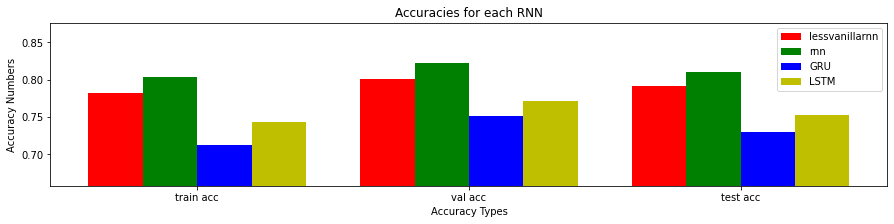

In [ ]:
import math

lessvanillarnn_final = [sum([i[0] for i in lessvanillarnn_results]) / 3, sum([i[1] for i in lessvanillarnn_results]) / 3, sum([i[2] for i in lessvanillarnn_results]) / 3]
rnn_final = [sum([i[0] for i in rnn_results]) / 3, sum([i[1] for i in rnn_results]) / 3, sum([i[2] for i in rnn_results]) / 3]
GRU_final = [sum([i[0] for i in GRU_results]) / 3, sum([i[1] for i in GRU_results]) / 3, sum([i[2] for i in GRU_results]) / 3]
LSTM_final = [sum([i[0] for i in LSTM_results]) / 3, sum([i[1] for i in LSTM_results]) / 3, sum([i[2] for i in LSTM_results]) / 3]

plt.rcParams["figure.figsize"] = (15,3)

categories = ["train acc", "val acc", "test acc"]

N = 3
ind = np.arange(N) 
width = 0.2


low = min(lessvanillarnn_final + rnn_final + GRU_final + LSTM_final)
high = max(lessvanillarnn_final + rnn_final + GRU_final + LSTM_final)
plt.ylim([low-0.5*(high-low), high+0.5*(high-low)])

bar1 = plt.bar(ind, lessvanillarnn_final, width, color = 'r')
bar2 = plt.bar(ind+width, rnn_final, width, color='g')
bar3 = plt.bar(ind+width*2, GRU_final, width, color = 'b')
bar4 = plt.bar(ind+width*3, LSTM_final, width, color = 'y')

  
plt.xlabel("Accuracy Types")
plt.ylabel('Accuracy Numbers')
plt.title("Accuracies for each RNN")
  
plt.xticks(ind+width*1.5, categories)
plt.legend( (bar1, bar2, bar3, bar4), ('lessvanillarnn', 'rnn', 'GRU', 'LSTM') )
plt.show()


The plot shows that on average, the regular RNN performed the best for all accuracy measurements, then the lessvanillarnn, LSTM, and finally the GRU. Perhaps the reson why the GRU and LSTM perform the worst is because we are not optimizing the hyperparameters for them to best capture the information in the data, with the regular RNN we don't need as much tuning to get an accurate enough result. The lessvanillarnn of course performs worse than the built in vanillarnn, since we haven't optimied any of the hyperparameters there either.

## Sharing information across cells

In [ ]:
class MethJointModel(nn.Module): # RNN that shares info across cells like HMM
    def __init__(self, rnn_layer, input_size, num_cells, embedding_size):
        super(MethJointModel, self).__init__()
        self.embed = nn.Linear(input_size, embedding_size)
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(rnn_layer.hidden_size, num_cells)

    def forward(self, meth, unmeth):
        x = torch.stack((meth,unmeth),3) # seq x batch x cells x channels(=meth and unmeth counts)
        x = self.embed(x) # seq x batch x cells x hidden_size
        x = x.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]) # seq x batch x (cells x hidden_size)
        x = F.relu(x)
        h = self.rnn_layer(x) 
        if isinstance(rnn_layer, nn.RNNBase): h = h[0] # torch RNN layers give h[0:t] and h[-1]
        output = self.linear(h)
        return output

In [ ]:
# train new methjointmodel

hidden_size = 32
num_cells = meth_mat.shape[1]
embedding_size = 3

rnn_layer = nn.LSTM(input_size = num_cells * embedding_size, hidden_size = hidden_size)

model = MethJointModel(rnn_layer, input_size = 2, num_cells = num_cells, embedding_size = embedding_size)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 100) # high dimensional: takes longer to converge

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Epoch 1 took 0.82s. Train loss: -0.5025 acc: 0.5634. Val loss: -0.5780 acc: 0.5896. Patience left: 10
Epoch 2 took 0.64s. Train loss: -0.5062 acc: 0.5848. Val loss: -0.5826 acc: 0.6077. Patience left: 10
Epoch 3 took 0.62s. Train loss: -0.5103 acc: 0.6002. Val loss: -0.5879 acc: 0.6205. Patience left: 10
Epoch 4 took 0.60s. Train loss: -0.5152 acc: 0.6106. Val loss: -0.5942 acc: 0.6299. Patience left: 10
Epoch 5 took 0.59s. Train loss: -0.5209 acc: 0.6176. Val loss: -0.6017 acc: 0.6379. Patience left: 10
Epoch 6 took 0.60s. Train loss: -0.5278 acc: 0.6240. Val loss: -0.6106 acc: 0.6459. Patience left: 10
Epoch 7 took 0.57s. Train loss: -0.5360 acc: 0.6308. Val loss: -0.6211 acc: 0.6536. Patience left: 10
Epoch 8 took 0.57s. Train loss: -0.5455 acc: 0.6375. Val loss: -0.6330 acc: 0.6608. Patience left: 10
Epoch 9 took 0.57s. Train loss: -0.5563 acc: 0.6435. Val loss: -0.6463 acc: 0.6674. Patience left: 10
Epoch 10 took 0.58s. Train loss: -0.5681 acc: 0.6486. Val loss: -0.6607 acc: 0.673

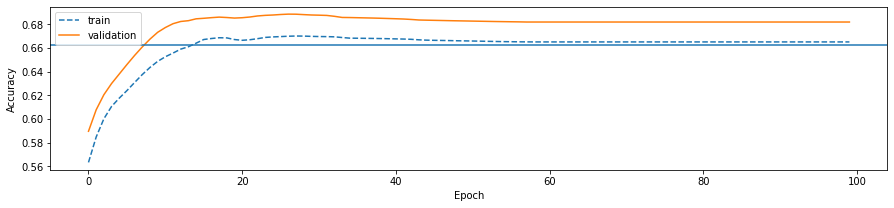

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_accs, "--", label="train")
plt.plot(val_accs, label="validation")
plt.axhline(test_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

## Compare performance of LSTM vs RNN vs GRU


In [ ]:
def run_model(layer):
  model = MethJointModel(layer, input_size = 2, num_cells = num_cells, embedding_size = embedding_size)

  device = "cuda"
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

  train_accs, val_accs = train_loop(model,
                                  optimizer,
                                  train_dataloader, 
                                  validation_dataloader,
                                  check_point_filename = 'rnn_checkpoint.pt',
                                  device = device,
                                  max_epochs = 100) # high dimensional: takes longer to converge

  test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
  print(test_acc)
  
  return (train_accs[-1], val_accs[-1], test_acc)
  
rnn_results2 = []
GRU_results2 = []
LSTM_results2 = []


In [ ]:
for i in range(3):
  hidden_size = 32
  num_cells = meth_mat.shape[1]
  embedding_size = 3

  rnn_layer = nn.RNN(input_size = num_cells * embedding_size, hidden_size = hidden_size)

  rnn_results2.append( run_model(rnn_layer) )

Epoch 1 took 0.66s. Train loss: -0.4884 acc: 0.4737. Val loss: -0.5638 acc: 0.4949. Patience left: 10
Epoch 2 took 0.59s. Train loss: -0.4944 acc: 0.5034. Val loss: -0.5708 acc: 0.5313. Patience left: 10
Epoch 3 took 0.55s. Train loss: -0.5007 acc: 0.5357. Val loss: -0.5783 acc: 0.5621. Patience left: 10
Epoch 4 took 0.52s. Train loss: -0.5074 acc: 0.5632. Val loss: -0.5864 acc: 0.5836. Patience left: 10
Epoch 5 took 0.51s. Train loss: -0.5146 acc: 0.5824. Val loss: -0.5949 acc: 0.5959. Patience left: 10
Epoch 6 took 0.51s. Train loss: -0.5223 acc: 0.5937. Val loss: -0.6038 acc: 0.6025. Patience left: 10
Epoch 7 took 0.51s. Train loss: -0.5303 acc: 0.6004. Val loss: -0.6133 acc: 0.6070. Patience left: 10
Epoch 8 took 0.50s. Train loss: -0.5388 acc: 0.6052. Val loss: -0.6231 acc: 0.6099. Patience left: 10
Epoch 9 took 0.52s. Train loss: -0.5477 acc: 0.6078. Val loss: -0.6335 acc: 0.6125. Patience left: 10
Epoch 10 took 0.51s. Train loss: -0.5570 acc: 0.6101. Val loss: -0.6443 acc: 0.617

In [ ]:
for i in range(3):
  hidden_size = 32
  num_cells = meth_mat.shape[1]
  embedding_size = 3

  gru_layer = nn.GRU(input_size = num_cells * embedding_size, hidden_size = hidden_size)

  GRU_results2.append( run_model(gru_layer) )

Epoch 1 took 0.70s. Train loss: -0.4959 acc: 0.4895. Val loss: -0.5731 acc: 0.5143. Patience left: 10
Epoch 2 took 0.60s. Train loss: -0.5006 acc: 0.5092. Val loss: -0.5785 acc: 0.5331. Patience left: 10
Epoch 3 took 0.56s. Train loss: -0.5054 acc: 0.5260. Val loss: -0.5842 acc: 0.5485. Patience left: 10
Epoch 4 took 0.55s. Train loss: -0.5104 acc: 0.5396. Val loss: -0.5902 acc: 0.5612. Patience left: 10
Epoch 5 took 0.56s. Train loss: -0.5157 acc: 0.5515. Val loss: -0.5967 acc: 0.5735. Patience left: 10
Epoch 6 took 0.56s. Train loss: -0.5214 acc: 0.5637. Val loss: -0.6038 acc: 0.5862. Patience left: 10
Epoch 7 took 0.55s. Train loss: -0.5277 acc: 0.5760. Val loss: -0.6117 acc: 0.5972. Patience left: 10
Epoch 8 took 0.55s. Train loss: -0.5345 acc: 0.5867. Val loss: -0.6204 acc: 0.6055. Patience left: 10
Epoch 9 took 0.56s. Train loss: -0.5421 acc: 0.5945. Val loss: -0.6300 acc: 0.6121. Patience left: 10
Epoch 10 took 0.55s. Train loss: -0.5505 acc: 0.6006. Val loss: -0.6406 acc: 0.619

In [ ]:
for i in range(3):
  hidden_size = 32
  num_cells = meth_mat.shape[1]
  embedding_size = 3

  lstm_layer = nn.LSTM(input_size = num_cells * embedding_size, hidden_size = hidden_size)

  LSTM_results2.append( run_model(lstm_layer) )

Epoch 1 took 0.56s. Train loss: -0.4985 acc: 0.5267. Val loss: -0.5752 acc: 0.5556. Patience left: 10
Epoch 2 took 0.58s. Train loss: -0.5029 acc: 0.5503. Val loss: -0.5805 acc: 0.5762. Patience left: 10
Epoch 3 took 0.59s. Train loss: -0.5077 acc: 0.5682. Val loss: -0.5864 acc: 0.5919. Patience left: 10
Epoch 4 took 0.57s. Train loss: -0.5131 acc: 0.5811. Val loss: -0.5929 acc: 0.6058. Patience left: 10
Epoch 5 took 0.58s. Train loss: -0.5190 acc: 0.5923. Val loss: -0.6001 acc: 0.6186. Patience left: 10
Epoch 6 took 0.57s. Train loss: -0.5255 acc: 0.6037. Val loss: -0.6081 acc: 0.6305. Patience left: 10
Epoch 7 took 0.58s. Train loss: -0.5327 acc: 0.6140. Val loss: -0.6169 acc: 0.6400. Patience left: 10
Epoch 8 took 0.57s. Train loss: -0.5407 acc: 0.6211. Val loss: -0.6266 acc: 0.6460. Patience left: 10
Epoch 9 took 0.58s. Train loss: -0.5494 acc: 0.6260. Val loss: -0.6370 acc: 0.6501. Patience left: 10
Epoch 10 took 0.57s. Train loss: -0.5587 acc: 0.6300. Val loss: -0.6480 acc: 0.652

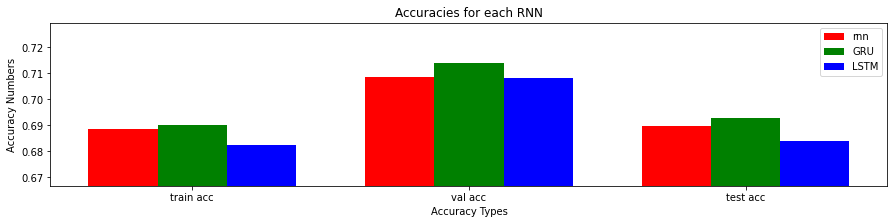

In [ ]:
import math

rnn_final2 = [sum([i[0] for i in rnn_results2]) / 3, sum([i[1] for i in rnn_results2]) / 3, sum([i[2] for i in rnn_results2]) / 3]
GRU_final2 = [sum([i[0] for i in GRU_results2]) / 3, sum([i[1] for i in GRU_results2]) / 3, sum([i[2] for i in GRU_results2]) / 3]
LSTM_final2 = [sum([i[0] for i in LSTM_results2]) / 3, sum([i[1] for i in LSTM_results2]) / 3, sum([i[2] for i in LSTM_results2]) / 3]

plt.rcParams["figure.figsize"] = (15,3)

categories = ["train acc", "val acc", "test acc"]

N = 3
ind = np.arange(N) 
width = 0.25


low = min(rnn_final2 + GRU_final2 + LSTM_final2)
high = max(rnn_final2 + GRU_final2 + LSTM_final2)
plt.ylim([low-0.5*(high-low), high+0.5*(high-low)])

bar1 = plt.bar(ind, rnn_final2, width, color = 'r')
bar2 = plt.bar(ind+width, GRU_final2, width, color='g')
bar3 = plt.bar(ind+width*2, LSTM_final2, width, color = 'b')

plt.xlabel("Accuracy Types")
plt.ylabel('Accuracy Numbers')
plt.title("Accuracies for each RNN")
  
plt.xticks(ind+width, categories)
plt.legend( (bar1, bar2, bar3), ('rnn', 'GRU', 'LSTM') )
plt.show()


Unlike the last trial, the GRU performs the best for each accuracy type, going pretty close to the accuraciies of RNN and with LSTM coming in the rear. The difference between the accuracies in this case though doesn't make much difference even though GRU is performing the best, the difference between average test accuraccy for GRU vs LSTM is less than 0.1, suggesting that it's possible for any of these three to produce the best results given experimentation with hyperparameters.